<a href="https://colab.research.google.com/github/sankalpachowdhury/Galaxy-Classification-using-CNN/blob/master/Model1_Galaxy_classification_sankalpa_v3-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras 
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline
import os, random, shutil

from keras_preprocessing import image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/Astronomical /Test.zip"

In [4]:
!unzip "/content/drive/My Drive/Galaxy_classification_project/images_training_rev1.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images_training_rev1/926426.jpg  
  inflating: images_training_rev1/926435.jpg  
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflati

In [3]:
df = pd.read_csv('/content/drive/My Drive/Galaxy_classification_project/training_solutions_rev1.csv')
#df_t = pd.read_csv('/content/drive/My Drive/Astronomical /Test.csv')

print(df.head)

<bound method NDFrame.head of        GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000        0.0   0.325512
1        100023  0.327001  0.663777  ...   0.000000        0.0   0.000000
2        100053  0.765717  0.177352  ...   0.000000        0.0   0.000000
3        100078  0.693377  0.238564  ...   0.000000        0.0   0.000000
4        100090  0.933839  0.000000  ...   0.000000        0.0   0.000000
...         ...       ...       ...  ...        ...        ...        ...
61573    999948  0.510379  0.489621  ...   0.000000        0.0   0.226257
61574    999950  0.901216  0.098784  ...   0.000000        0.0   0.000000
61575    999958  0.202841  0.777376  ...   0.000000        0.0   0.072296
61576    999964  0.091000  0.909000  ...   0.023065        0.0   0.045334
61577    999967  0.767000  0.140000  ...   0.000000        0.0   0.023380

[61578 rows x 38 columns]>


In [4]:
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new

In [5]:
df.shape

(61578, 38)

In [6]:
df.head(5)

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,Q5.1,Q5.2,Q5.3,Q5.4,Q6.1,Q6.2,Q7.1,Q7.2,Q7.3,Q8.1,Q8.2,Q8.3,Q8.4,Q8.5,Q8.6,Q8.7,Q9.1,Q9.2,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [9]:
ellipticals = df[(df['Q1.1']>0.8) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()
#ellipticals

In [10]:

lenticulars = df[(df['Q1.1']>0.8) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()
#lenticulars

In [11]:
spirals = df[(df['Q1.2']>0.8) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()
#spirals

In [12]:
print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  4555
Total number of lenticular examples:  3861
Total number of spiral examples:  3078


In [13]:
source_path = '/content/images_training_rev1'
dest_path = '/content/data'

In [14]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')


In [15]:

_proc_images(source_path, dest_path, 'elliptical', ellipticals, 0.9)
_proc_images(source_path, dest_path, 'lenticular', lenticulars, 0.9)
_proc_images(source_path, dest_path, 'spiral', spirals, 0.9)

elliptical done!
lenticular done!
spiral done!


Data Processing

In [16]:
import os
import PIL
import PIL.Image

In [ ]:
'''
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.transform import resize

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    # x = resize(x, shape)
    x = x/255.
    return x

def get_all_images(path,df,shape=IMG_SHAPE, crop_size=CROP_SIZE, orig_size = ORIG_SHAPE, r=600):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = df.values
    ids = sel[:r,0].astype(int).astype(str)
    y_batch = sel[:r,1:]
    x_batch = []
    for i in tqdm(ids):
      
      x = get_image(path+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
      x_batch.append(x)
    print(i)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
            
x_train, y_train = get_all_images('/content/Train/',df)
x_test, y_test = get_all_images('/content/Test/',df_t)
print(x_train.shape)
print(y_train.shape)
print(type(y_train))
print(x_test.shape)
print(y_test.shape)
print(type(y_test))
'''

"\nimport matplotlib.pyplot as plt\n\nfrom tqdm import tqdm\nfrom skimage.transform import resize\n\nORIG_SHAPE = (424,424)\nCROP_SIZE = (256,256)\nIMG_SHAPE = (64,64)\n\ndef get_image(path, x1,y1, shape, crop_size):\n    x = plt.imread(path)\n    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]\n    # x = resize(x, shape)\n    x = x/255.\n    return x\n\ndef get_all_images(path,df,shape=IMG_SHAPE, crop_size=CROP_SIZE, orig_size = ORIG_SHAPE, r=600):\n    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2\n    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2\n   \n    sel = df.values\n    ids = sel[:r,0].astype(int).astype(str)\n    y_batch = sel[:r,1:]\n    x_batch = []\n    for i in tqdm(ids):\n      \n      x = get_image(path+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)\n      x_batch.append(x)\n    print(i)\n    x_batch = np.array(x_batch)\n    return x_batch, y_batch\n            \nx_train, y_train = get_all_images('/content/Train/',df)\nx_test, y_test = get_all_images('/content/Test/',df_t)\nprint(x_tr

In [28]:
!pip install Augmentor

In [29]:
import Augmentor

p1 = Augmentor.Pipeline(source_directory='/content/data/train/elliptical',output_directory = '/content/Data1/Train/elliptical')
p2 = Augmentor.Pipeline(source_directory='/content/data/train/lenticular',output_directory = '/content/Data1/Train/lenticular')
p3 = Augmentor.Pipeline(source_directory='/content/data/train/spiral',output_directory = '/content/Data1/Train/spiral')

#Defining our method of Image Augmentation
p1.rotate90(probability=0.5)
p1.rotate270(probability=0.5)
p1.flip_left_right(probability=0.8)
p1.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p1.resize(probability=1.0, width=150, height=150)

p2.rotate90(probability=0.5)
p2.rotate270(probability=0.5)
p2.flip_left_right(probability=0.8)
p2.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p2.resize(probability=1.0, width=150, height=150)

p3.rotate90(probability=0.5)
p3.rotate270(probability=0.5)
p3.flip_left_right(probability=0.8)
p3.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p3.resize(probability=1.0, width=150, height=150)

p1.sample(5000)
p2.sample(5000)
p3.sample(5000)

Initialised with 4099 image(s) found.
Output directory set to /content/Data1/Train/elliptical.Initialised with 3474 image(s) found.
Output directory set to /content/Data1/Train/lenticular.

Executing Pipeline:   0%|          | 0/5000 [00:00<?, ? Samples/s]

Initialised with 2770 image(s) found.
Output directory set to /content/Data1/Train/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCC837ACC0>: 100%|██████████| 5000/5000 [00:32<00:00, 152.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCC6C4D1470>: 100%|██████████| 5000/5000 [00:33<00:00, 150.40 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCB00930B8>: 100%|██████████| 5000/5000 [00:32<00:00, 151.72 Samples/s]


In [7]:
train_dir = '/content/Data1/Train'
validation_dir = 'data/validation'
# make a directory in colabs "data" and copy the path.

In [8]:

total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Total train: 15000
Total validation: 1151


In [9]:
# parameters
target = (150, 150)
batch_size = 32

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=target,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         class_mode='categorical')

Found 15000 images belonging to 3 classes.
Found 1151 images belonging to 3 classes.


In [11]:
r_coeff = 0.001

In [ ]:
'''
from keras import regularizers


model = keras.models.Sequential([keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
                                keras.layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.MaxPooling2D((20,20),strides=(2,2)),
                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.MaxPooling2D((2,2)),# Deafault takes stride = (2,2)
                                keras.layers.Flatten(),
                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Dense(3,activation = 'softmax',kernel_regularizer = regularizers.l2(r_coeff))
                                ])
#model1.add()
model.summary()
'''

"\nfrom keras import regularizers\n\n\nmodel = keras.models.Sequential([keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),\n                                keras.layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer = regularizers.l2(r_coeff)),\n                                keras.layers.MaxPooling2D((20,20),strides=(2,2)),\n                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),\n                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),\n                                keras.layers.MaxPooling2D((2,2)),# Deafault takes stride = (2,2)\n                                keras.layers.Flatten(),\n                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),\n                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.

In [12]:
from keras import regularizers


model2 = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    
    # 512 neuron fully connected hidden layer
    #tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
#model1.add()
#tf.keras.layers.Dropout(0.5),
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [ ]:
from keras import regularizers
from keras.layers import BatchNormalization

model3 = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
#model1.add()
#tf.keras.layers.Dropout(0.5),
model3.summary()

In [15]:
from tensorflow.keras.optimizers import Adam 

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])
#(learning_rate=0.001)

In [16]:
EPOCHS = 50

In [17]:
from keras.callbacks import TensorBoard
from time import time

# Create a TensorBoard instance with the path to the logs directory
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

history = model2.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    #callbacks=[plot_lossesd],
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
469/469 [==============================] - 86s 182ms/step - loss: 0.6657 - acc: 0.6350 - val_loss: 0.5306 - val_acc: 0.7272
Epoch 2/50
469/469 [==============================] - 87s 186ms/step - loss: 0.4995 - acc: 0.7421 - val_loss: 0.4984 - val_acc: 0.7585
Epoch 3/50
469/469 [==============================] - 86s 183ms/step - loss: 0.4426 - acc: 0.7871 - val_loss: 0.4413 - val_acc: 0.8054
Epoch 4/50
469/469 [==============================] - 86s 183ms/step - loss: 0.4147 - acc: 0.8041 - val_loss: 0.4703 - val_acc: 0.7950
Epoch 5/50
469/469 [==============================] - 85s 182ms/step - loss: 0.3911 - acc: 0.8199 - val_loss: 0.4049 - val_acc: 0.8175
Epoch 6/50
469/469 [==============================] - 86s 183ms/step - loss: 0.3885 - acc: 0.8202 - val_loss: 0.3977 - val_acc: 0.8367
Epoch 7/50
469/469 [==============================] - 86s 183ms/step - loss: 0.3796 - acc: 0.8252 - val_loss: 0.37

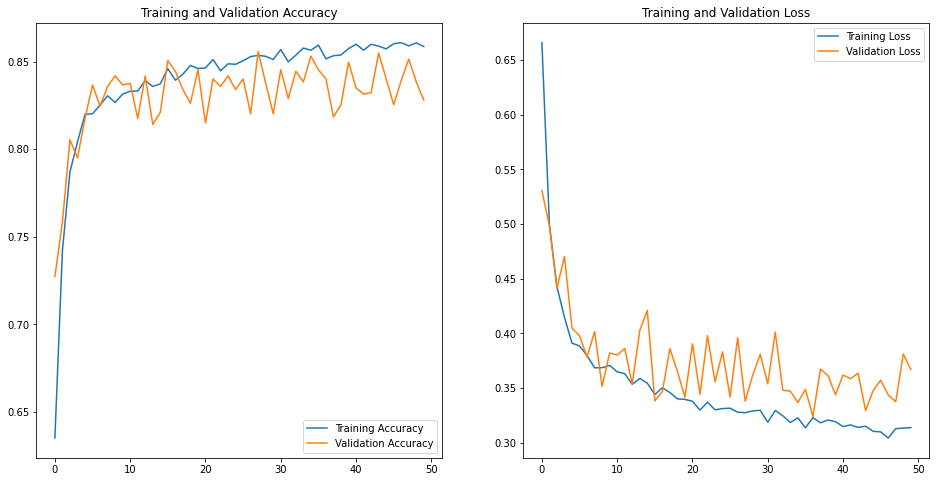

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
'''
model.fit(x_train, y_train, batch_size = 64, epochs= EPOCHS, validation_data=(x_test, y_test))


history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    verbose=1)
'''

In [ ]:
model.save('galaxy-convnet-v2.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [ ]:
!pip install Tensorboard



filter size = (fh=3, fw = 3, fc = 3)
nc[l+1] = 32
w.shape = 32*(3*3*3) = 864
b.shape = 32
total = 896

TUMI OFF KORE DIYO LAPTOP< OKK

In [ ]:
tensorboard --logdir=logs/


In [ ]:
# launch TensorBoard (data won't show up until after the first epoch)
tensorboard("logs/run_a")

TypeError: ignored

In [ ]:
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_lossesd = PlotLosses()